## Recover spectra from model predictions

We use the percentiles and metallicity predicted by our model to generate spectra as a linear combination of MILES SSP spectra with these ages and metallicity.

Import modules and define format of the plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy import  integrate
import os
from astropy.io import fits
from tqdm import tqdm,trange
from scipy.optimize import curve_fit
from matplotlib import gridspec
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['xtick.labelsize'] = 'medium'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'medium'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['font.size'] = 30
mpl.rcParams["figure.figsize"] = (15,10)
mpl.rcParams["mathtext.fontset"]='dejavuserif'

Load data (real observations, pPXF predictions and medians and standard deviations of the posteriors predicted by our model)

In [3]:
#observations
seds=np.load('/Users/patriglesiasnavarro/Desktop/ULL/Master/Segundo/TFM/programas/github/BNN_SFHs/observations/obs/processed/seds.npy')
wave=np.load('/Users/patriglesiasnavarro/Desktop/ULL/Master/Segundo/TFM/programas/github/BNN_SFHs/observations/obs/processed/wave.npy')
sigma_gal=np.load('sigma_obs.npy')

#ppxf
ages=np.load('ages_ppxf.npy')
weights=np.load('weights_ppxf.npy')
met_ppxf=np.load('met_ppxf.npy')
met_weights=np.load('met_weights.npy')

#model
post_obs_median=np.load('./post_median.npy')
post_obs_stds=np.load('./post_stds.npy')


Load tools to load and combine MILES SSP spectra with observational features

In [2]:
from generate_input_obs import *

Starting dense_basis. Failed to load FSPS, only GP-SFH module will be available.


Quick visualization check: percentiles given by our model, percentiles obtained from pPXF and observed spectra preprocessed, using a colormap based on the velocity dispersion

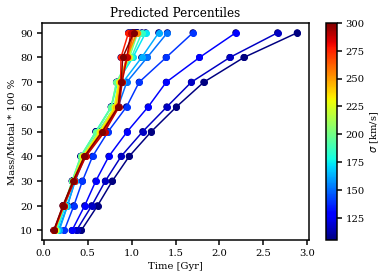

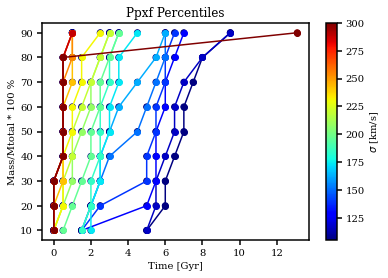

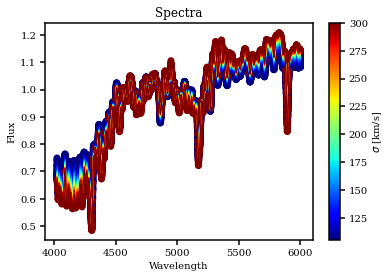

In [11]:
colors=plt.cm.jet(np.linspace(0,1,18))
fig,ax=plt.subplots()

for i in np.arange(18): 
    ax.plot(post_obs_median[i,:9],np.arange(10,100,10),'-o',c=colors[i])
    plt.scatter(post_obs_median[i,:9],np.arange(10,100,10),marker=None,c=sigma_gal[i]*np.ones((9)),cmap='jet')
plt.title('Predicted Percentiles') 
plt.xlabel('Time [Gyr]')
plt.ylabel('Mass/Mtotal * 100 %')
plt.colorbar(label='$\\sigma$ [km/s]')
plt.clim(105,300)
plt.show()

fig,ax=plt.subplots()
for i in np.arange(18): 
    ax.plot(percent_ppxf[i,:9][::-1],np.arange(10,100,10),'-o',c=colors[i])
    plt.scatter(percent_ppxf[i,:9][::-1],np.arange(10,100,10),marker=None,c=sigma_gal[i]*np.ones((9)),cmap='jet')
plt.title('Ppxf Percentiles') 
plt.xlabel('Time [Gyr]')
plt.ylabel('Mass/Mtotal * 100 %')
plt.colorbar(label='$\\sigma$ [km/s]')
plt.clim(105,300)
plt.show()

fig,ax=plt.subplots()
for i in np.arange(18): 
    ax.plot(wave,seds[i,:],c=colors[i],lw=1)
    plt.scatter(wave,seds[i,:],marker=None,c=sigma_gal[i]*np.ones((1978)),cmap='jet')
plt.title('Spectra')
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.colorbar(label='$\\sigma$ [km/s]')
plt.clim(105,300)

plt.show()

Let's get from the percentiles predicted by our model the non-cumulative mass curve

In [6]:
#save non accumulative mass curves obtained from predicted percentiles 
def derivative(predictions):
    """Derivate the percentiles to get the non-cumulative mass curve (weights of the linear combination of spectra)

    Parameters
    ----------
    predictions: array of size (number of observations = 18, number of features predicted = 10)
            Values predicted for the percentiles and metallicity
        
    Returns
    -------
    ms_from_percentiles_pred: array of size (number of observations = 18, number of percentiles = 9)
            Derivative of the percentiles (non-cumulaltive mass curves)
    """
    delta_t=0.01348046441147335
    ms_from_percentiles_pred=[]
    for i in range(18):
        per=predictions[i,:9]
        ms=np.gradient(np.arange(0.1,1,0.1),per) #unit Msun/gyr
        ms_from_percentiles_pred.append(ms*delta_t) #unit Msun
    ms_from_percentiles_pred=np.array(ms_from_percentiles_pred)
    return ms_from_percentiles_pred

ms_from_percentiles_pred=derivative(post_obs_median) #for the median
ms_from_percentiles_pred_sigma=derivative(post_obs_median+2*post_obs_stds) #for the median + 2std
ms_from_percentiles_pred_sigma_=derivative(post_obs_median-2*post_obs_stds) #for the median - 2std

100%|██████████| 18/18 [00:00<00:00, 5258.58it/s]


"#show non accumulative mass curve (unit Msun)\nfor i in range(18):\n    ms=ms_from_percentiles_pred[i]\n    per=post_obs_median[i,:9]\n    \n    plt.plot(per,ms,'-o',color='k',label='From  percentiles')\n    plt.plot(per+2*post_obs_stds[i,:9],ms_from_percentiles_pred_sigma[i],':',color='k',label='median + 2sigma')\n    plt.plot(per-2*post_obs_stds[i,:9],ms_from_percentiles_pred_sigma_[i],'--',color='k',label='median - 2sigma')\n    plt.legend(loc='upper right')\n    plt.xlabel('Time [Gyr]')\n    plt.ylabel('Non acumulative mass curves [$M_{\\odot}$]')\n    plt.show()"

We recreate the observed spectra from the posteriors predicted by our model for the percentiles (previously derived to get the non-cumulative mass curve, i.e the weights) and the metallicity.

In [7]:
def spectrum_from_percentiles(predictions):
    """Spectra generated as a linear combination of MILES SSP spectra with the weights coming from the non-cumulative mass curve derived from the percentile predictions of the model and metallicity fixed by the predictions.

    Parameters
    ----------
    predictions: array of size (number of observations = 18, number of features predicted = 10)
            Values predicted for the percentiles and metallicity
        
    Returns
    -------
    seds_from_percent: list of arrays
                       18 arrays containing the normalized flux of the linear combinations for each observation
    """

    z=predictions[:,-1] #metallicities predicted by the model

    #load MILES spectra with these metallicities
    dir1='/Users/patriglesiasnavarro/Desktop/ULL/Master/Segundo/TFM/programas/github/BNN_SFHs/MILES/MILES_BASTI_KU_baseFe'
    tbins=get_tbins(dir_name=dir1,strs_1='Mku1.30Zp0.06T',strs_2='_iTp0.00_baseFe.fits')
    wave,data_met=get_data_met(dir_name=dir1[:-7],z=z)
    data=[]
    for i in range(18):
        data.append(data_met[:,:,i])


    #Get the weights and perform the linear combination interpolating previously 

    seds_from_percent=[]

    for i in range(18):
        
        ms=derivative(predictions)
        #notice we need to interpolate using lookback time (MILES)
        data_extended=interpolate_t(tbins,14-predictions[i,:9],data[i])
        spectrum=[]
        
        for l in range(9):  #we append older first
            spectrum.append(((1/9)*data_extended[-l]))
            
        spectrum=np.array(spectrum)
        sed_from_percent=np.sum(spectrum,axis=0) #we add the terms of the linear combination
        seds_from_percent.append(sed_from_percent/np.median(sed_from_percent))
    return seds_from_percent


#Obtain the reconstruction of the spectra for the median of the posteriors predicted, the #median + 2 sigma and the median - 2 sigma
seds_from_percent= spectrum_from_percentiles(post_obs_median)
seds_from_percent_sigma= spectrum_from_percentiles(post_obs_median+2*post_obs_stds)
seds_from_percent_sigma_= spectrum_from_percentiles(post_obs_median-2*post_obs_stds)

100%|██████████| 18/18 [00:00<00:00, 9113.65it/s]


Do a plot for each observation comparing the spectrum reconstructed and the real spectra, showing the residuals in a lower frame

100%|██████████| 18/18 [00:00<00:00, 9687.86it/s]


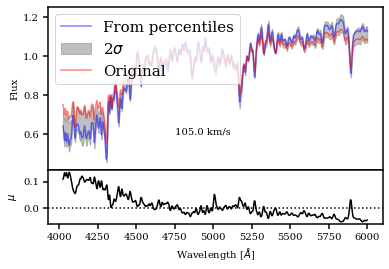

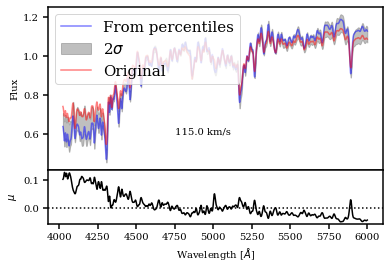

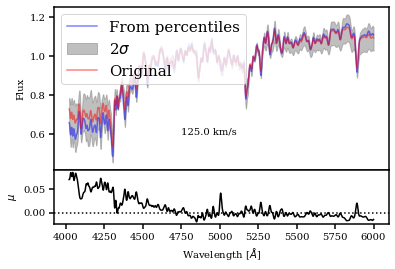

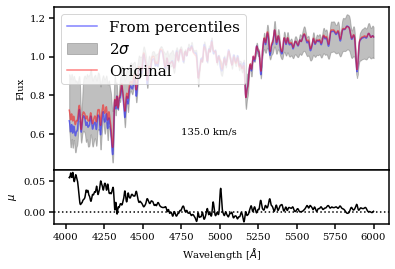

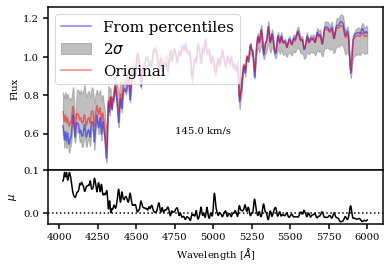

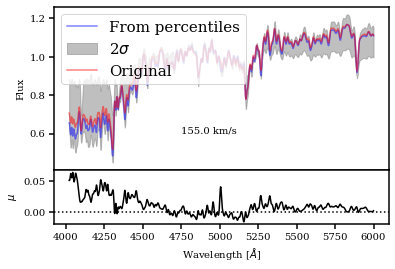

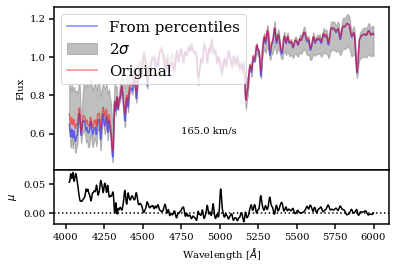

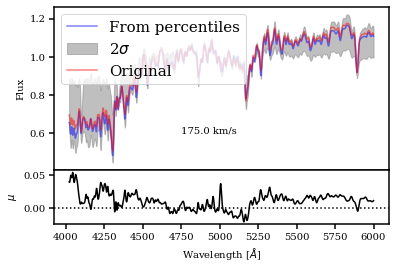

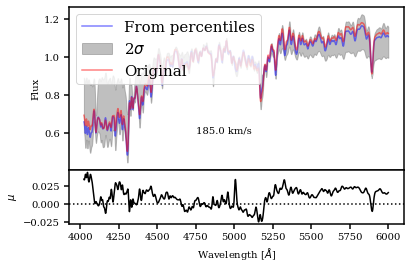

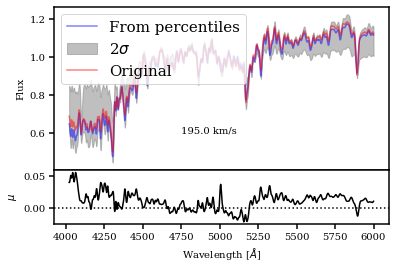

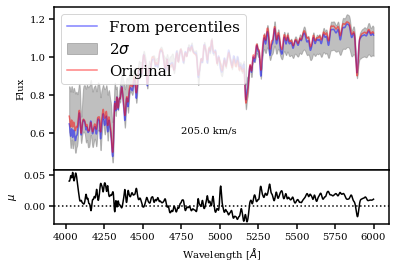

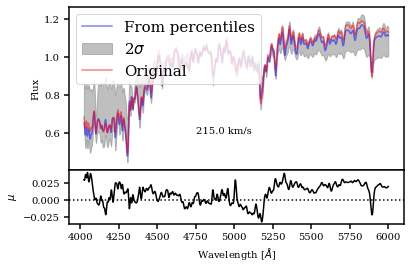

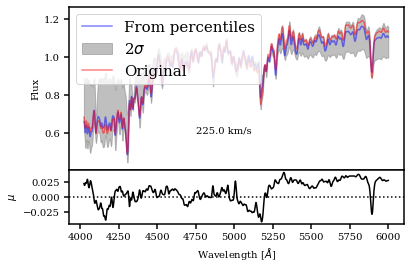

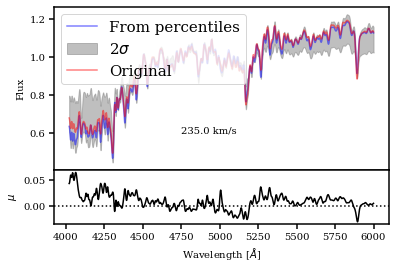

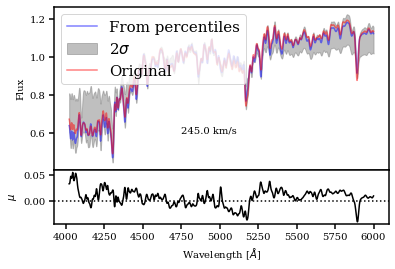

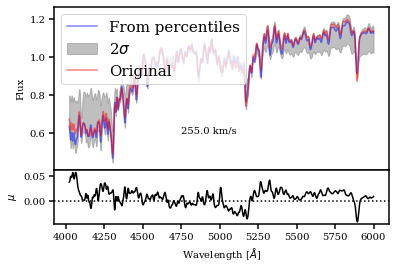

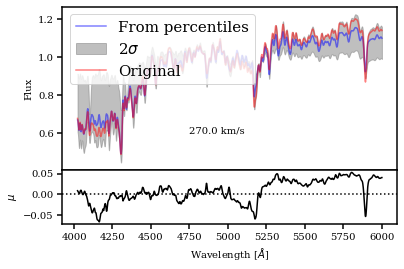

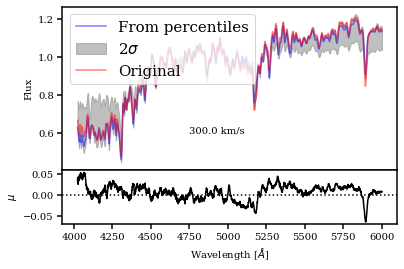

In [20]:


for i in range(18):
    fig = plt.figure()
    # set height ratios for subplots
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 


    #first subplot (upper frame)
    ax0 = plt.subplot(gs[0])
    ax0.plot(w, seds_from_percent[i],'b',label='From percentiles',alpha=0.5)
    ax0.fill_between(x=w, y1=seds_from_percent_sigma[i],y2=seds_from_percent_sigma_[i],color='grey',label='2$\\sigma$',alpha=0.5)
    ax0.plot(w, seds[i,:],'r',label='Original',alpha=0.5) 
    ax0.set_ylabel('Flux')   
    ax0.legend(loc='upper left',fontsize=15)

    #second subplot (lower frame)
    ax1 = plt.subplot(gs[1], sharex = ax0)
    ax1.plot(w,(seds[i,:]-seds_from_percent[i]),'k')
    ax1.axhline(0,0,1,ls=':',c='k')
    ax1.set_xlabel('Wavelength [$\\AA$]')
    ax1.set_ylabel('$\\mu$')
    
    yticks = ax1.yaxis.get_major_ticks()
    yticks[-1].label1.set_visible(False)
    plt.subplots_adjust(hspace=.0)
    plt.setp(ax0.get_xticklabels(), visible=False)
    ax0.text(4750,0.6,str(sigma_gal[i])+' km/s')
    #plt.savefig('./examples/no_norm'+str(k)+'.jpg')
    plt.show()
    

Do the reconstruction combining MILES spectra of different ages and metallicity from the weights given by pPXF

In [58]:
w=np.arange(4023,6001)


def spectrum_from_ppxf(ages,weights,met,met_weights):
    """Spectra generated as a linear combination of MILES SSP spectra with the weights coming from the weights of pPXF.

        Parameters
        ----------
        ages: array, size (34,)
              Ages considered by pPXF

        weights: array, size (34,)
                Weights for the ages considered by pPXF

        met: array, size (12,)
             Metallicities considered by pPXF   

        met_weights: array, size (12,)
                     Weights for the metallicities considered by pPXF
            
        Returns
        -------
        seds_from_ppxf: list of arrays
                        18 arrays containing the normalized flux of the linear combinations for each observation
        """
    
    dir1='/Users/patriglesiasnavarro/Desktop/ULL/Master/Segundo/TFM/programas/github/BNN_SFHs/MILES/MILES_BASTI_KU_baseFe'

    tbins=get_tbins(dir_name=dir1,strs_1='Mku1.30Zp0.06T',strs_2='_iTp0.00_baseFe.fits')
  
    seds_from_ppxf=[]

    for i in tqdm(range(18)):
        sed_from_ppxf_met=[]
        met_weights_reshaped=np.zeros((12,1978))

        for a,z in enumerate(met[0]):
            if met_weights[i][a]>1e-12: #weights different than zero
                wave,data_met=get_data_met(dir_name=dir1[:-7],z=[z])
                data_extended=interpolate_t(tbins,ages[i],data_met[:,:,0])
                spectrum=[]
                for l in range(34): 
                    spectrum.append(weights[i,l]*np.array(data_extended[-l]))
                spectrum=np.array(spectrum)
                sed_from_ppxf_met.append(np.sum(spectrum,axis=0)) #we add the terms of the linear combination
            
            else: #weights equal to zero
                sed_from_ppxf_met.append(np.zeros((1978,)))

            met_weights_reshaped[a,:]=met_weights[i][a]*np.ones((1978))
            
        
        final_spectra=np.sum(met_weights_reshaped*sed_from_ppxf_met,axis=0)
        seds_from_ppxf.append(final_spectra/np.median(final_spectra))
    return seds_from_ppxf

seds_from_ppxf=spectrum_from_ppxf(ages,weights,met_ppxf,met_weights)

#save because it takes a lot of time
np.save('seds_ppxf.npy',seds_from_ppxf)

100%|██████████| 18/18 [09:32<00:00, 31.82s/it]


Load spectra reconstructed using pPXF

In [8]:
seds_from_ppxf=np.load('seds_ppxf.npy')

Compare the reconstructions of our model and pPXF with the true values of the spectra, for each observation, plotting the residuals in a lower panel

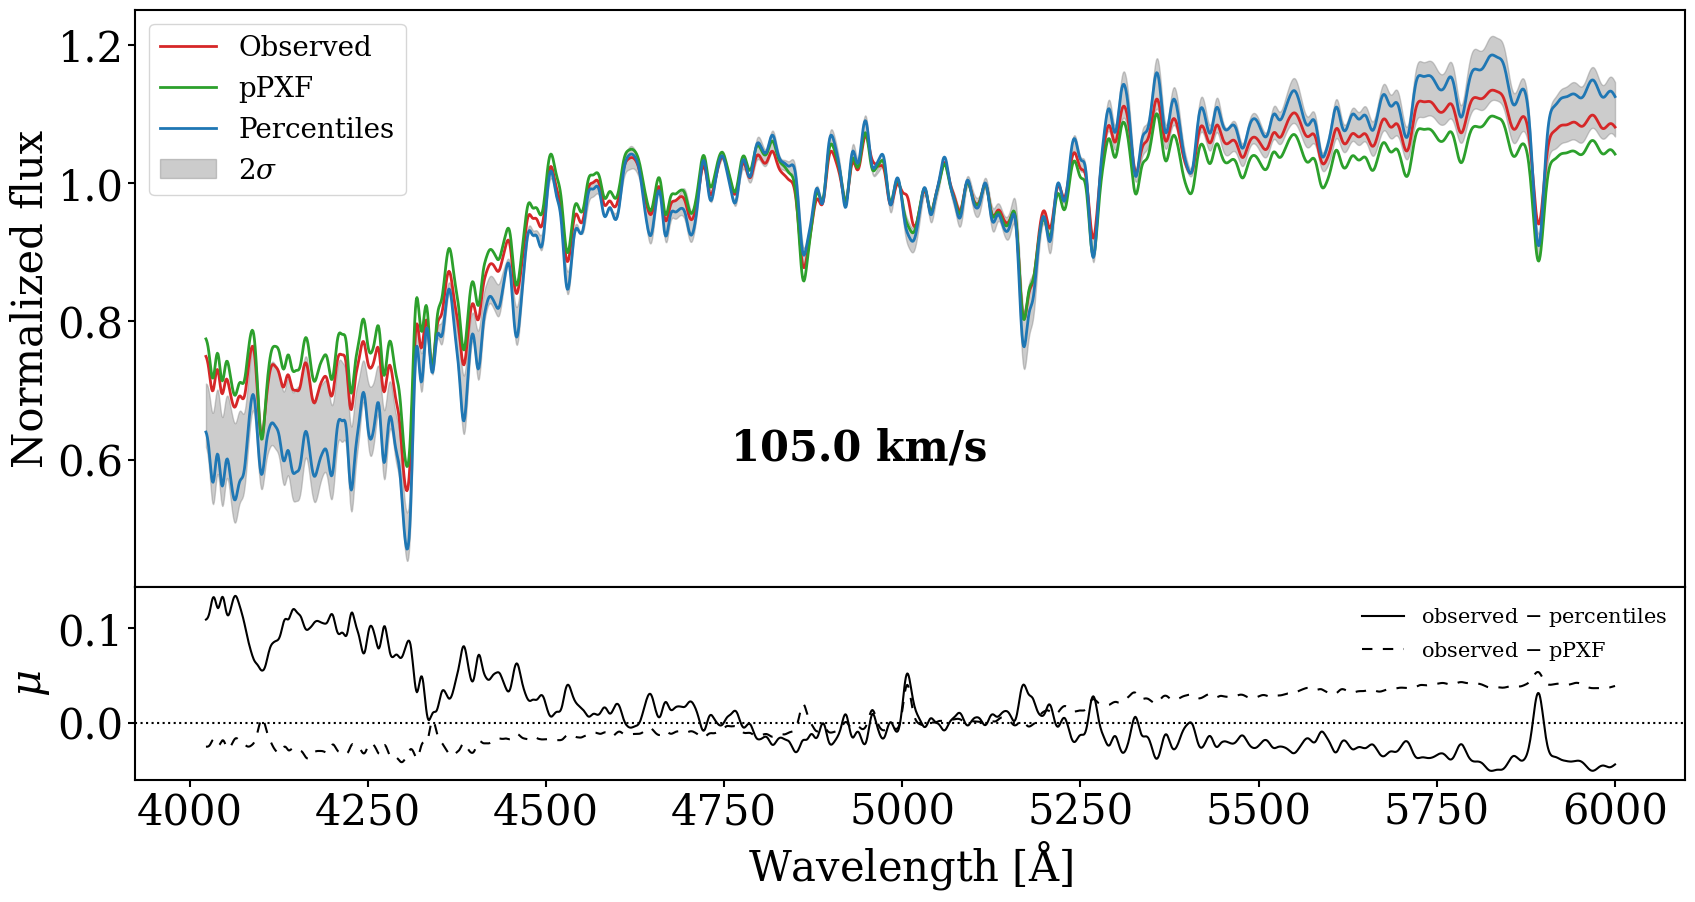

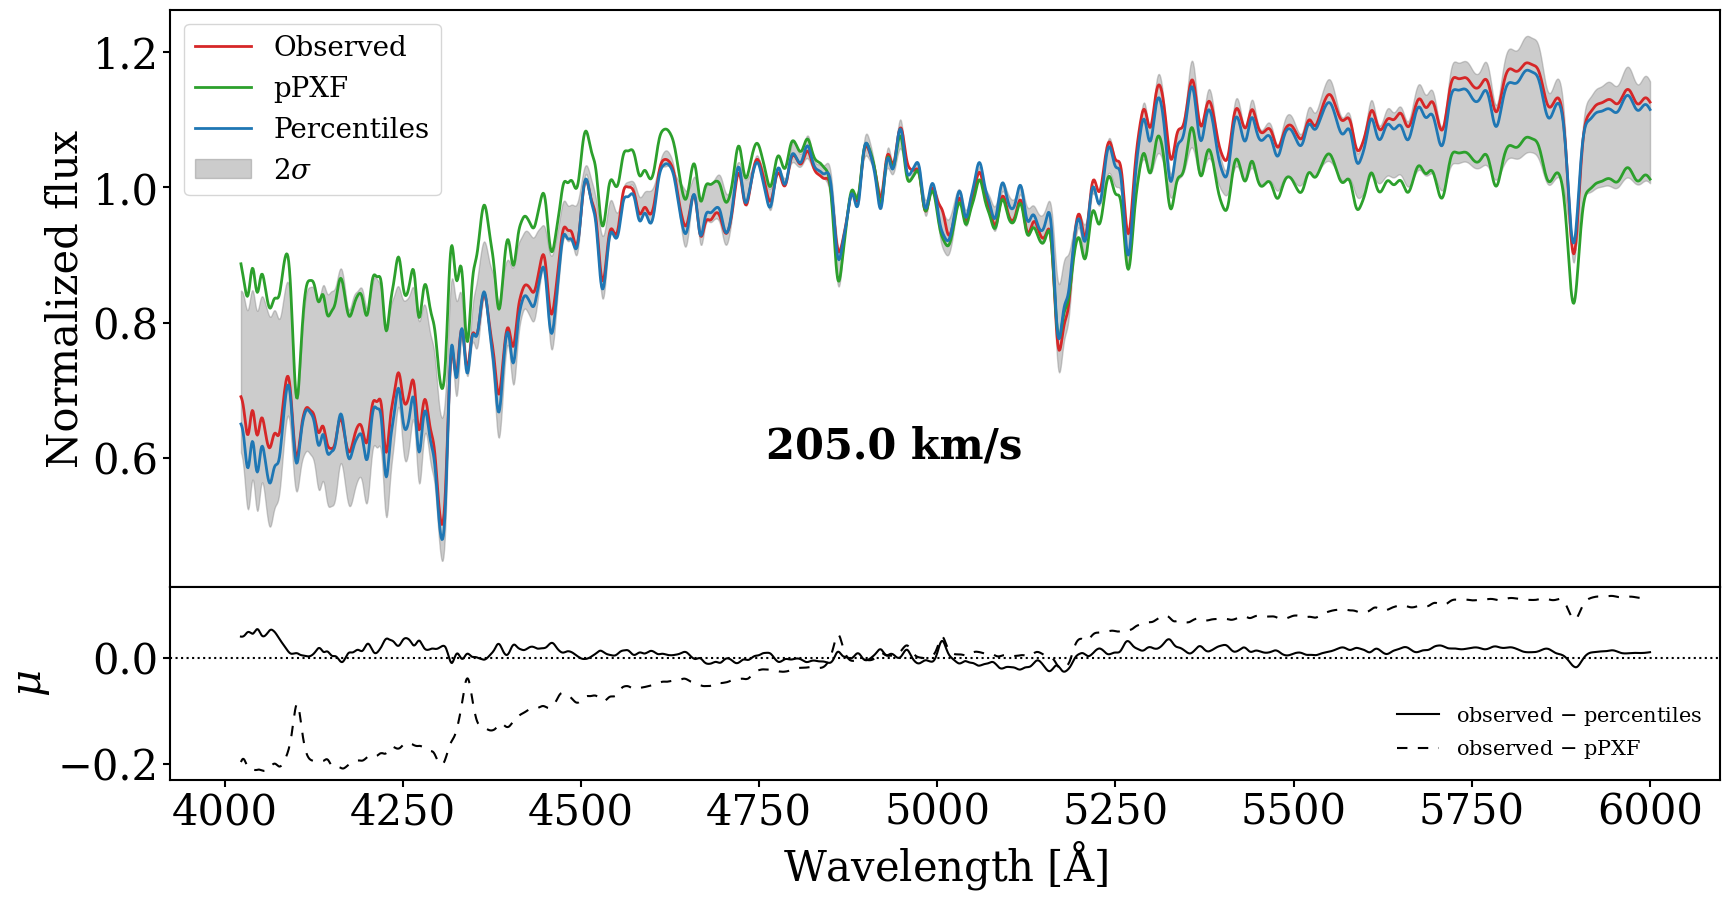

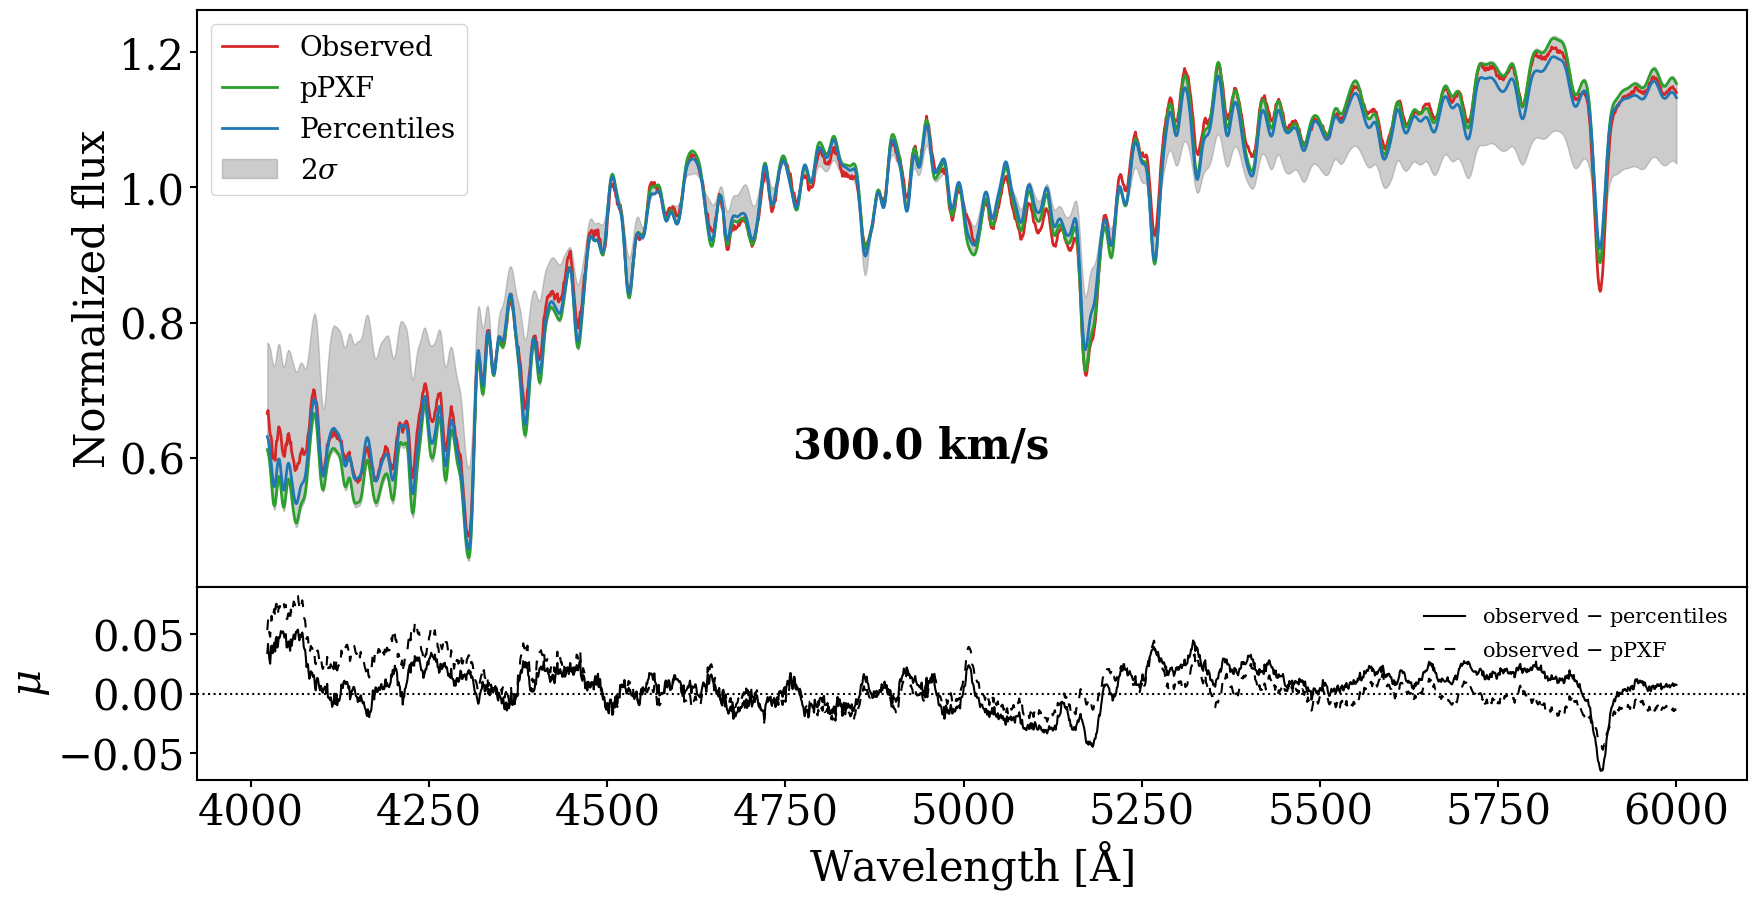

In [11]:
w=np.arange(4023,6001)

for i in [0,10,17]:#range(18):
    fig = plt.figure(figsize=(20,10))
    # set height ratios for subplots
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    # the first subplot
    ax0 = plt.subplot(gs[0])

    ax0.plot(w, seds[i,:],'tab:red',label='Observed',lw=2) 
    ax0.plot(w, seds_from_ppxf[i],'tab:green',label='pPXF',lw=2)
    ax0.plot(w, seds_from_percent[i],'tab:blue',label='Percentiles',lw=2)
    ax0.fill_between(x=w, y1=seds_from_percent_sigma[i],y2=seds_from_percent_sigma_[i],color='grey',label='2$\\sigma$',alpha=0.4)

    ax0.set_ylabel('Normalized flux')   
    ax0.legend(loc='upper left',fontsize=20)


    
    ax1 = plt.subplot(gs[1], sharex = ax0)
    ax1.plot(w,(seds[i,:]-seds_from_percent[i]),'-k',label='observed $-$ percentiles')
    ax1.plot(w,(seds[i,:]-seds_from_ppxf[i]),'k',label='observed $-$ pPXF',ls='--',dashes=(5, 5))
    ax1.axhline(0,0,1,ls=':',c='k')
    ax1.set_xlabel('Wavelength [$\\rm \\AA$]')
    ax1.set_ylabel('$\\mu$')

    if i==17:
        ax1.legend(fontsize=15,frameon=False,loc='upper right')
    else:
        ax1.legend(fontsize=15,frameon=False)
    
    yticks = ax1.yaxis.get_major_ticks()
    yticks[-1].label1.set_visible(False)
    plt.subplots_adjust(hspace=.0)
    plt.setp(ax0.get_xticklabels(), visible=False)
    ax0.text(4760,0.6,str(sigma_gal[i])+' km/s',weight='bold')
    if i in [0,10,17]:
        plt.savefig('./spectra_'+str(sigma_gal[i])+'.pdf',bbox_inches="tight")
    plt.show()

Compute where we do achieve better performance than pPXF

In [61]:
#Residuals
best_ppxf=[]
best_percentiles=[]
for i in range(18):
    a=np.sum(np.abs(seds[i,:]-seds_from_ppxf[i]))
    b=np.sum(np.abs(seds[i,:]-seds_from_percent[i]))
    if a>b:
        best_percentiles.append(i)
    else:
        best_ppxf.append(i)

#Maximum discrepancy
a_s=[]
b_s=[]
for i in range(18):
    a_s.append(np.max(np.abs(seds[i,:]-seds_from_ppxf[i])))
    b_s.append(np.max(np.abs(seds[i,:]-seds_from_percent[i])))

print(np.max(a_s),np.max(b_s))  

#Mean discrepancy
a_s=[]
b_s=[]
for i in range(18):
    a_s.append(np.mean(np.abs(seds[i,:]-seds_from_ppxf[i])))
    b_s.append(np.mean(np.abs(seds[i,:]-seds_from_percent[i])))

print(np.mean(a_s),np.mean(b_s))   

print('pPXF performs better in: ', sigma_gal[best_ppxf])
print('NFs performs better in: ', sigma_gal[best_percentiles])
    

43.20151323634863 65.9812906846559
33.661495344606536 61.33932433397804
25.57344214391405 32.596750328476965
26.754032851922158 23.409409229885927
22.675091550779317 35.93542105169759
23.965428921660212 25.022623996971113
24.49709189208169 25.339109177173544
47.76391864202952 25.83644535237032
30.22142910151154 26.746443739701675
144.97625409889955 27.03963504805092
162.23323372551044 26.618155543756387
186.58191692897174 29.922632596972782
205.5725302027622 33.96272510080578
245.41146273099002 26.993350327474644
264.4895862141789 26.970373911771926
254.55606792062878 28.050884596798483
245.08596798183436 44.90437403592171
29.48771084517463 28.847933533299987
